In [36]:
from landlab import RasterModelGrid
from gravel_bedrock_eroder.gravel_bedrock_eroder import GravelBedrockEroder
from landlab.components import FlowAccumulator
from ClastGrading import ClastGrading
from matplotlib import pyplot as plt
import numpy as np

In [50]:
# Global parameters
porosity = 0.4                              # [-]
soil_density = 2650                         # [kg/m^3]
initial_sediment_weight_at_node = 100000    # [kg]
n_steps = 500

""" Create grading features with different fragmentation models. 
Fragmentation models are describe by the following string:
      !!   pX-AAA-BBB-CCC-DDD'  !!       
while
X = number of daughter particles
AAA = weight % that *REMAINS* in  parent after fragmentation
BBB / CCC / DDD ... = proportion of daughters '
"""
grading_name = 'p2-0-100'  # ,'p2-10-10-spread'  #,'p2-0-100'

In [51]:
# Create grid
grid = RasterModelGrid((3, 3), xy_spacing=1000.0)
elev = grid.add_zeros("topographic__elevation", at="node")

In [52]:
# Flag for an apriori grain size disribution OR for generating a distribution
known_dist_flag = False

if known_dist_flag:
    mean_grainsize_per_class = [0.002, 0.02, 0.2, 2, 10]  # [0.002, 0.2, 1 ]  # [m]
    init_median_grainsize_at_node = 0.2           # [m]
    n_size_classes = np.size(mean_grainsize_per_class )
    A_factor = 0.001
else:
    init_median_grainsize_at_node = 0.1           # [m]
    n_size_classes = 30
    maxsize = 2
    A_factor = 0.01

In [53]:
# Call ClastGrading component
grading = ClastGrading(
    grid,
    grading_name=grading_name,
    n_size_classes=n_size_classes,
    clast_density=soil_density,
    phi=porosity,
)

In [54]:
if known_dist_flag:
    grading.set_grading_classes(input_sizes_flag=True,
                                meansizes=mean_grainsize_per_class,
                                )
    grading.create_transion_mat(A_factor=A_factor)
    
    # Create grain size distribution for initial debris layer
    grading.create_dist(
        median_size=init_median_grainsize_at_node,
        num_of_clasts=initial_sediment_weight_at_node,
        init_val_flag=True,
    std=1)

else:

    grading.set_grading_classes(maxsize = maxsize)
    grading.create_transion_mat(A_factor=A_factor)
    # Create grain size distribution for initial debris layer
    grading.create_dist(
        median_size=init_median_grainsize_at_node,
        num_of_clasts=initial_sediment_weight_at_node,
        init_val_flag=True, )

In [55]:
grid.at_node['soil__depth']

array([  6.28930818e-05,   6.28930818e-05,   6.28930818e-05,
         6.28930818e-05,   6.28930818e-05,   6.28930818e-05,
         6.28930818e-05,   6.28930818e-05,   6.28930818e-05])

In [56]:
# Call other components 
fa = FlowAccumulator(grid, runoff_rate=10.0)
fa.run_one_step()
eroder = GravelBedrockEroder(
    grid, sediment_porosity = 0.4, abrasion_coefficients = [0.0005]
)

In [57]:
# Boundary conditions
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[5] = grid.BC_NODE_IS_FIXED_VALUE

In [58]:
# Pointers
rock_elev = grid.at_node["bedrock__elevation"]

# save inital weight per grain size
init_weight_per_grainsize = np.copy(grid.at_node['grain__weight'][3,:])

In [59]:
# MAIN LOOP
for _ in range(n_steps ):
    rock_elev[grid.core_nodes] += 1.0
    elev[grid.core_nodes] += 1.0
    fa.run_one_step()
    eroder.run_one_step(10000.0)
    grading.run_one_step()

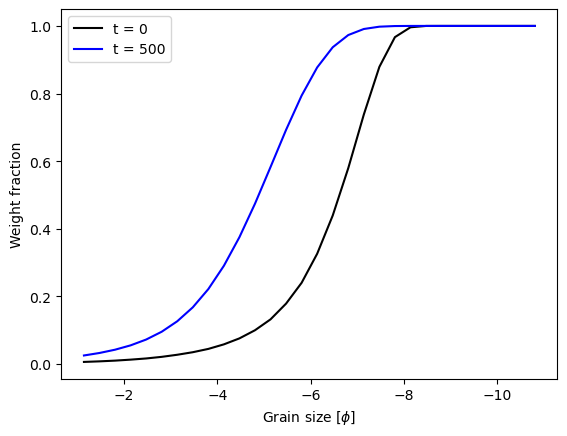

In [61]:
# Figure
total_weight = np.sum(grid.at_node['grain__weight'][3,:])
fig,ax = plt.subplots(1,1)
ax.plot(-np.log2(grading._meansizes*1000),
        np.cumsum(init_weight_per_grainsize)/total_weight,
        color='black',
       label='t = 0')
ax.plot(-np.log2(grading._meansizes*1000),np.cumsum(grid.at_node['grain__weight'][3,:])/total_weight,color='blue',label='t = ' + str(n_steps ))
ax.set_xlabel('Grain size [$\phi$]')
ax.set_ylabel('Weight fraction')
ax.invert_xaxis() # phi scale
ax.legend()
plt.show()

In [48]:
init_weight_per_grainsize

array([  6.77000000e+02,   1.93000000e+02,   2.03000000e+02,
         2.72000000e+02,   3.28000000e+02,   5.23000000e+02,
         6.59000000e+02,   7.68000000e+02,   9.26000000e+02,
         1.35400000e+03,   1.79300000e+03,   2.41500000e+03,
         3.22200000e+03,   4.59800000e+03,   6.26200000e+03,
         8.56000000e+03,   1.12300000e+04,   1.40900000e+04,
         1.56670000e+04,   1.40680000e+04,   8.77900000e+03,
         2.99600000e+03,   4.03000000e+02,   1.40000000e+01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [37]:
grading.update_sizes()